# [NML24] QM9_test





In [617]:
# Importing dependencies
%matplotlib inline

from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import torch
from sklearn import metrics
from tqdm import tqdm
import assignment3_utils as utils
from placeholder import PlaceHolder, to_dense, er_validation_step

# Set device
utils.seed_everything(0)
device = "cuda:0" if torch.cuda.is_available() else "cpu"  # cuda index to be changed
print('current device:', device)

current device: cpu


# **Part 1: Loading QM9 dataset**


In [618]:
total_dataset_np = np.load("C:/Users/alexk/OneDrive/Documents/Classes/Network_ML/assignment3/qm9_skeleton_9_nodes_345.npy")

In [675]:
print(f"len(total_dataset_np): {len(total_dataset_np)}")
total_num_edgs=0
for data in total_dataset_np:
    total_num_edgs+=np.triu(data).sum()
print(f"total_num_edgs: {total_num_edgs}")
print(f"average_num_edgs: {total_num_edgs/len(total_dataset_np)}")
print(f"average_connectiviy: {total_num_edgs/((len(total_dataset_np)*36))}")

len(total_dataset_np): 345
total_num_edgs: 3813.0
average_num_edgs: 11.052173913043479
average_connectiviy: 0.3070048309178744


In [676]:
train_indices = np.random.choice(len(total_dataset_np), 300, replace=False)
train_dataset_np = total_dataset_np[train_indices]
test_dateset_np = total_dataset_np[np.delete(np.arange(len(total_dataset_np)), train_indices)] # get the rest as test dataset

In [677]:
nx_dataset={}

In [678]:
nx_dataset["train"]=[nx.from_numpy_matrix(data) for data in train_dataset_np]
nx_dataset["test"]=[nx.from_numpy_matrix(data) for data in test_dateset_np]

In [679]:
print(nx_dataset["train"][0].edges)
print(nx_dataset["train"][0].nodes)
print(nx_dataset["train"][0].number_of_edges())

[(0, 1), (0, 8), (1, 2), (1, 4), (2, 3), (2, 4), (2, 8), (3, 4), (4, 5), (4, 8), (5, 6), (6, 7), (7, 8)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
13


In [680]:
print(f"len(train_dataset_np): {len(train_dataset_np)}")
train_num_edgs=0
for data in train_dataset_np:
    np.fill_diagonal(data, 0)
    transformed_data=np.triu(data)
    train_num_edgs+=transformed_data.sum()
print(f"train_num_edgs: {train_num_edgs}")
print(f"average_num_edgs: {train_num_edgs/len(train_dataset_np)}")
print(f"average_connectiviy: {train_num_edgs/(len(train_dataset_np)*36)}")

len(train_dataset_np): 300
train_num_edgs: 3307.0
average_num_edgs: 11.023333333333333
average_connectiviy: 0.3062037037037037


In [681]:
print(f"len(nx_dataset['train']): {len(nx_dataset['train'])}")
print(f"len(nx_dataset['test']): {len(nx_dataset['test'])}")

len(nx_dataset['train']): 300
len(nx_dataset['test']): 45


In [682]:
# Average degree for the training set
train_avg_degree = np.mean([np.mean(list(dict(nx_graph.degree()).values())) for nx_graph in nx_dataset["train"]])
print(f"train_avg_degree: {train_avg_degree}")

# Average clustering coefficient for the training set
train_avg_clustering = np.mean([np.mean(list(nx.clustering(nx_graph).values())) for nx_graph in nx_dataset["train"]])
print(f"train_avg_clustering: {train_avg_clustering}")


total_dataset=[nx.from_numpy_matrix(data) for data in total_dataset_np]
total_avg_degree = np.mean([np.mean(list(dict(nx_graph.degree()).values())) for nx_graph in total_dataset])
print(f"total_avg_degree: {total_avg_degree}")

total_avg_clustering = np.mean([np.mean(list(nx.clustering(nx_graph).values())) for nx_graph in total_dataset])
print(f"total_avg_clustering: {total_avg_clustering}")

#print average connectivity for nx graphs
total_num_edgs=0
for nx_graph in total_dataset:
    total_num_edgs+=nx_graph.number_of_edges()
print(f"average_num_edgs: {total_num_edgs/(len(total_dataset)*36)}")

train_avg_degree: 2.4496296296296296
train_avg_clustering: 0.23156790123456786
total_avg_degree: 2.456038647342995
total_avg_clustering: 0.23662909286097691
average_num_edgs: 0.3070048309178744


### ER model  for comparison

In [683]:
def generate_ER_graph(n: int, p_er: float) -> nx.Graph:
    graph = nx.Graph()
    graph.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if np.random.rand() < p_er:
                graph.add_edge(i, j)
    return graph
 

In [684]:
class ER_prob_model():
    def __init__(self) -> None:
        pass

    def fit(self, dataset):
        self.p = self.estimate_p(dataset)
        self.n_dist = self.estimate_n_cat_dist(dataset)
        print(f"Estimated p: {self.p}")
        print(f"Estimated n categorical distribution: {self.n_dist}")

    def estimate_n_cat_dist(self, dataset: List[nx.Graph]) -> Dict[int, float]:
        """Output must be a dictionary where keys are the number of nodes and values are the probability of that number of nodes."""
        n_dist = {}
        for g in dataset:
            n = g.number_of_nodes()
            if n in n_dist:
                n_dist[n] += 1
            else:
                n_dist[n] = 1
        for n in n_dist:
            n_dist[n] /= len(dataset)
        return n_dist

    def estimate_p(self, dataset: List[nx.Graph]) -> float:
        """Output must be a single floating point number representing the probability of an edge existing between two nodes."""
        p = sum([g.number_of_edges() for g in dataset]) / sum([g.number_of_nodes() * (g.number_of_nodes() - 1) / 2 for g in dataset])
        return p

    def sample_ER_graphs(self, n_graphs: int) -> List[nx.Graph]:
        """Output must be a list of n_graphs ER graphs sampled from the model. Note that you should use the estimated parameters, self.n_dist and self.p (see `fit` function)."""
        graphs = []
        for _ in range(n_graphs):
            n = np.random.choice(list(self.n_dist.keys()), p=list(self.n_dist.values()))
            graph = nx.Graph()
            graph.add_nodes_from(range(n))
            for i in range(n):
                for j in range(i+1, n):
                    if np.random.rand() < self.p:
                        graph.add_edge(i, j)
            graphs.append(graph)
        return graphs

In [685]:
train_dataset = nx_dataset["train"]
num_graphs_to_generate = len(nx_dataset["test"])

# Learn the parameters of the ER model using the training dataset
er_model = ER_prob_model()
er_model.fit(train_dataset)

# Generate ER graphs using the learned model and visualizing the first 5
graphs_to_eval = {}
graphs_to_eval["ER"] = er_model.sample_ER_graphs(num_graphs_to_generate)

Estimated p: 0.3062037037037037
Estimated n categorical distribution: {9: 1.0}


In [686]:
# Average degree for the training set
train_avg_degree = np.mean([np.mean(list(dict(nx_graph.degree()).values())) for nx_graph in graphs_to_eval["ER"]])
print(f"train_avg_degree: {train_avg_degree}")

# Average clustering coefficient for the training set
train_avg_clustering = np.mean([np.mean(list(nx.clustering(nx_graph).values())) for nx_graph in graphs_to_eval["ER"]])
print(f"train_avg_clustering: {train_avg_clustering}")

total_num_edgs=0
for nx_graph in graphs_to_eval["ER"]:
    total_num_edgs+=nx_graph.number_of_edges()
print(f"average_num_edgs: {total_num_edgs/(len(graphs_to_eval['ER'])*36)}")


train_avg_degree: 2.4740740740740743
train_avg_clustering: 0.21730746619635505
average_num_edgs: 0.30925925925925923


# **Part 2: Digress without marginal probabiliteis**




In [687]:
import placeholder
import importlib
from placeholder import PlaceHolder

In [688]:
def count_n_node(dataset: List[nx.Graph]) -> np.ndarray:
    """Output must be a numpy array of shape (max_n_nodes + 1,) containing the probability of each number of nodes in the dataset, where max_n_nodes is the highest number of nodes found for a single graph in the dataset."""
    max_n_nodes=max([g.number_of_nodes() for g in dataset])
    prob = np.zeros(max_n_nodes + 1)
    for g in dataset:
        prob[g.number_of_nodes()] += 1
    prob /= len(dataset)
    return prob

n_nodes_dist = torch.tensor(count_n_node(nx_dataset['train']))
max_n_nodes = len(n_nodes_dist)-1
print(f"The maximum number of nodes is: {max_n_nodes}")
print(f"The distribution of node numbers is: {n_nodes_dist}")


The maximum number of nodes is: 9
The distribution of node numbers is: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=torch.float64)


### Question 2.2 - Discrete Diffusion Process [6 points]

In this part, we will simulate a discrete diffusion process over $T=1000$ steps. Discrete diffusion involves gradually corrupting categorical data towards a random distribution. For example, a vector $[0,1,0,0]$ might evolve under noise to $[0.1,0.7,0.1,0.1]$ at step $t=200$, and eventually reach a uniform distribution like $[0.25, 0.25, 0.25, 0.25]$ at $t=T=1000$.

The process utilizes a transition matrix $Q_t$ for each step $t$ in $[1,...,T]$, which is a square matrix of size $(k,k)$, where $k$ is the number of categories. The matrix $Q_t$  can be computed with $Q_t=\alpha^t \mathbb{I} + \beta^t \mathbf{1} \mathbf{1}'/n$, where $\mathbf{1}'$ is the transpose of the array $\mathbf{1}$, fully filled with ones, of size $(n, 1)$. It combines two components:
- An identity matrix $\mathbb{I}$ scaled by $\alpha^t$, preserving the original data distribution.
- A matrix $\mathbf{1} \mathbf{1}'/k$ where all entries are $1/k$, scaled by $\beta^t$, representing the noise based on a uniform distribution. Here, $\beta^t$ increases from 0 to 1 as $t$ approaches $T$, with $\alpha^t = 1 - \beta^t$.

The transition matrix $ Q_t $, defining transitions from step $ t $ to $ t+1 $, incrementally introduces noise at each step, perturbing the original distribution. In particular, the entry $Q_t[i, j]$ defines the probability of an edge (in this case, but it works for any other modelling variable laying in a discrete state-space) going from state $i$ at timestep $t$ to state $j$ at timestep $t+1$. This process is mathematically guaranteed to approach a uniform categorical distribution as $ T $ becomes large, where $T $ represents the total number of diffusion steps.

The $\beta^t$ values follow a predefined schedule, which is implemented in the following code.


We provide some introduction to the Markov chain here, in case you need.

For a Markov chain with a finite state space, the transition probabilities can be represented in a square matrix $ P $ where each element $ P_{ij} $ of the matrix represents the probability of moving from state $ i $ to state $ j $ in one step. Mathematically, $ P_{ij} $ is defined as:
$$ P_{ij} = \Pr(X_{n+1} = j \mid X_n = i) $$
where $ X_n $ is the state at time $ n $. For the matrix $ P $ to be valid, each row must satisfy the following conditions:
- $ 0 \leq P_{ij} \leq 1 $
- $ \sum_{j \in S} P_{ij} = 1 $ for all $ i \in S $

In [689]:
T = 1000

all_betas = utils.get_betas(timesteps=T, s=0.008)
all_alphas = utils.get_alphas(timesteps=T)
all_alphas_bar = utils.get_alphas_bar(all_alphas)

In [690]:
print(f"all_alphasa_bar shape: {all_alphas_bar.shape}")

all_alphasa_bar shape: torch.Size([1001, 1])


**2.2.2. [4 points]** **Implement the computation** for $Q_t$ and $\bar{Q}_t$ for edges according to the definition above.

Hint: to make the implementation easier, you do not compute $\mathbf{1}\mathbf{1}'/k$ to create the noise matrix; instead, we define the noise distribution $\mathbf{1}'/k$ (of size `(2)` denoted as noise_dist in the following function) then expand it's dimensions to reach the correct sizes (`bs, 2, 2`).

In [691]:
def get_Q_t(betas: torch.Tensor, noise_dist: torch.Tensor, e_class=2) -> torch.Tensor:
    """
    Input:
        - betas, (bs, )
        - noise_dist, (e_class, 1) -> the noise distribution at step $t=1,000$, here we take by default (0.5, 0.5)
        - e_class, number of classes for edges
    Output:
        - q_e, (bs, e_class, e_class)
    """

    q_e = torch.zeros(betas.shape[0], e_class, e_class)
    for i in range(e_class):
        q_e[:, i, i] = 1 - (betas*noise_dist.sum()).view(-1)
    noise=noise_dist.unsqueeze(0).repeat(e_class,1)
    for batch in range(betas.shape[0]):
        q_e[batch,:,:]=q_e[batch,:,:]+betas[batch]*noise 
    assert ((q_e.sum(dim=2) - 1.0).abs() < 1e-4).all()  # ensure each row of q_e represents a distribution
    return q_e

def get_Q_t_bar(alphas_bar: torch.Tensor, noise_dist: torch.Tensor, e_class: int =2) -> torch.Tensor:
    """
    Input:
        - alphas_bar, (bs, )
        - noise_dist, (e_class, 1) -> the noise distribution at step $t=1,000$, here we take by default (0.5, 0.5)
        - e_class, number of classes for edges
    Output:
        - q_e, (bs, e_class, e_class)
    """

    q_e = torch.zeros(alphas_bar.shape[0], e_class, e_class)
    for i in range(e_class):
        q_e[:, i, i] = alphas_bar.view(-1)
    noise=noise_dist.unsqueeze(0).repeat(e_class,1)
    for batch in range(alphas_bar.shape[0]):  
        q_e[batch,:,:]=q_e[batch,:,:]+(1-alphas_bar[batch])*noise
    assert ((q_e.sum(dim=2) - 1.0).abs() < 1e-4).all()  # ensure each row of q_e represents a distribution
    return q_e


# example for test
noise_dist = torch.Tensor([0.5, 0.5])
betas_t = utils.get_betas(1000)[:2]
alphas_bar_t = utils.get_alphas_bar(utils.get_alphas(1000))[:2]
Qt = get_Q_t(betas_t, noise_dist, e_class=2)
Qt_bar = get_Q_t_bar(alphas_bar_t, noise_dist, e_class=2)

print(f"Qt: {Qt}, {Qt.shape}")
print(f"Qt_bar: {Qt_bar}, {Qt_bar.shape}")


Qt: tensor([[[9.9998e-01, 2.0620e-05],
         [2.0620e-05, 9.9998e-01]],

        [[9.9998e-01, 2.3044e-05],
         [2.3044e-05, 9.9998e-01]]]), torch.Size([2, 2, 2])
Qt_bar: tensor([[[9.9995e-01, 5.0008e-05],
         [5.0008e-05, 9.9995e-01]],

        [[9.9990e-01, 1.0002e-04],
         [1.0002e-04, 9.9990e-01]]]), torch.Size([2, 2, 2])


### Question 2.3 - Apply Noise to Data [5 points]

Now that the components of discrete diffusion are completed, we can proceed to corrupt graphs!

To achieve this, you will implement a function called `apply_noise` that introduces noise to the data. This function will take a `PlaceHolder` object as input and return a noisy `PlaceHolder` object. As we are working with unattributed graphs, we will only apply noise to the edges.

**2.3.1. [5 points]** **Complete the implementation** of the `corrupt_edges` function. You should
- Compute the corrupted edge probability distribution with `Qtb`(need to be computed by yourself) and `E`;
- Sample the noisy edges `E_t` from the corrupted multinomial distribution. Remember that the noisy edges `E_t` to return should be symmetrical and in one-hot encoding form, as they are realizations and not distributions.

In [692]:
def corrupt_edges(E: torch.Tensor, t_int: torch.Tensor, noise_dist: torch.Tensor, node_mask: torch.Tensor):
    bs = E.size(0)
    n = E.size(1)  # number of nodes
    de = len(noise_dist)  # number of edge classes, i.e., 2

    idx = t_int.to('cpu').squeeze(-1)
    Qt_bar=get_Q_t_bar(all_alphas_bar[idx], noise_dist, de)
    probE = torch.zeros(bs, n, n, de)
    for i in range(bs):
        probE[i] = E[i].matmul(Qt_bar[i])
    
    inverse_edge_mask = ~(node_mask.unsqueeze(1) * node_mask.unsqueeze(2))
    diag_mask = torch.eye(n).unsqueeze(0).expand(bs, -1, -1)
    probE[inverse_edge_mask] = 1 / probE.shape[-1]
    probE[diag_mask.bool()] = 1 / probE.shape[-1]
    probE = probE.reshape(bs * n * n, -1)    # (bs * n * n, de_out)
    E_t = torch.multinomial(probE, 1).reshape(bs, n, n,1)
    upper_triangle = torch.triu(E_t.squeeze(), diagonal=0)  
    symmetric_matrix = upper_triangle + upper_triangle.transpose(1, 2) - torch.diag_embed(upper_triangle.diagonal(dim1=-2, dim2=-1))  
    E_t = symmetric_matrix.unsqueeze(-1)
    E_t= torch.nn.functional.one_hot(E_t, de).float().squeeze()
    return E_t

def apply_noise(holder, T, noise_dist, node_mask):
    t_int = torch.randint(1, T + 1, size=(holder.E.size(0), 1))
    E = holder.E
    E_t = corrupt_edges(E, t_int, noise_dist, node_mask)
    return PlaceHolder(X=holder.X, E=E_t, y=holder.y).mask(node_mask), t_int

# example for test
n = 2
bs = 3
E = torch.Tensor([[0,1],[1,0]]).repeat(bs, 1, 1).long()
E = torch.nn.functional.one_hot(E, 2).float()
holder = PlaceHolder(X=torch.ones(bs, n, 1), E=E, y=None)
noise_dist = torch.Tensor([0.5, 0.5])
node_mask = torch.ones(bs, n).bool()

# apply_noise(holder, 1000, noise_dist, node_mask)[0].E[1,:,:,0]

### Question 2.4 - Model Implementation [6 points]

In this part, we will begin the deep learning phase by designing a GNN model architecture.

In this project, a graph $G$ is represented by node features $X$ of size $(n, 1)$ and edge features $E$ of size $(n, n, 2)$. We will employ a graph transformer to model the interactions among nodes. This approach enables the integration of quadratic edge features into the attention layer, enhancing the model's ability to capture complex relationships within the graph.

More precisely, the model will take a PlaceHolder as input and return a PlaceHolder as output. The input PlaceHolder should contain $X$, $E$, and the graph feature $y$, where $y$ includes at least the time information $t$ of the diffusion process (where $t \in [0, 1000]$ and $T=1,000$). $G_0$ refers to a clean graph, while $G_t$ refers to a noised graph at step $t$. The output PlaceHolder should contain the predicted distribution (probabilities) over the clean graph $\hat{E}_0$ (X can be ignored as we set them to be 1 at all steps) given a noised graph.

But, dealing with the dense tensors of size $[bs, n, n, 2]$ could be challenging for implementing given the requirement of frequent masking. So, in this section, we start by an easier model and leverage a sparse graph representation supported directly by `pytorch geometric`. This model should be composed of a GNN trunk (whose architecture you can choose freely) to extract node features from the input graph, and some MLP layers for link prediction (in this case, prediction of probabilities for edge classes). More precisely:
- The GNN trunk should takes node features and edge index as input (several `pytorch geometric` models are readily available, fell free to use them), and output node features;
- Build input features for the MLP layers  from the previous node features. Note that the input features to the MLP for the prediction of $e_{i,j}$ should be invariant to the order of the nodes, i.e.,
for the edge prediction module `m` we should have a good `m(x_i, x_j)=m(x_j, x_i)
- These node ordering invariant edge features should be passed to the MLP layers for edge classification (probabilities prediction over edge classes).

**2.4.1. [6 points]** **Complete the simple model** architecture given in the following block.
<!-- - Define your own gnn network, and obtain node_embedding with it.
- After this, you need to perform the link prediction between all node pairs with your own link prediction module $l$, remember that $l(e_1, e_2)=l(e_2, e_1)$.
- Remember that the number of nodes for different graphs are different, so that you may need to add some masks for link prediction.
- The block should output `output_E` which is of size $(bs, n, n, 2)$. -->

In [693]:
import torch.nn as nn
from torch_geometric.nn.models import MLP, GIN, GAT
from torch_geometric.data import Batch, Data
from torch_geometric.utils import dense_to_sparse
from itertools import combinations

def collapse_placeholder(holder):
    E = torch.argmax(holder.E, dim=-1)
    return PlaceHolder(X=holder.X, E=E, y=holder.y)

def holder_to_data_batch(holder, node_mask):
    # WARNING: holder should already be masked!
    data_list = []
    holder = collapse_placeholder(holder)

    for graph_idx in range(holder.X.size(0)):
        this_node_mask = node_mask[graph_idx]
        n_nodes = this_node_mask.sum()
        X = holder.X[graph_idx].squeeze()
        X = X[this_node_mask]
        E = holder.E[graph_idx]
        edge_index, edge_attr = dense_to_sparse(adj=E[:n_nodes, :n_nodes])
        y = holder.y[graph_idx]
        data = Data(x=X, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data.validate(raise_on_error=True)
        data_list.append(data)

        data_batch = Batch.from_data_list(data_list)

    return data_batch

In [694]:
class SimpleModel(nn.Module):
    def __init__(self,
                 input_dims: int,
                 num_GNN_layers: int,
                 hidden_dims: int,
                 num_MLP_layers: int,
                 hidden_MLP_dims: int,
                 output_dims: int):
        super().__init__()
        self.gnn = GIN(
            in_channels=input_dims,
            out_channels=hidden_dims,
            num_layers=num_GNN_layers,
            hidden_channels=hidden_dims,
            train_eps=False
        )
        self.mlp = MLP(
            in_channels=hidden_dims,
            hidden_channels=hidden_MLP_dims,
            out_channels=output_dims,
            num_layers=num_MLP_layers,
        )

    def forward(self, holder: PlaceHolder, node_mask: torch.Tensor) -> PlaceHolder:
        max_n_nodes = holder.E.shape[1]
        bs=holder.X.size(0)
        data = holder_to_data_batch(holder, node_mask)

        # add timestep concatenating in node features
        time = data.y
        x, edge_index = data.x, data.edge_index
        time_as_x = time[data.batch].unsqueeze(-1)
        x = torch.hstack((x.unsqueeze(-1), time_as_x))
        node_embeddings = self.gnn(x[:,:-1], edge_index)
        padded_node_embeddings = torch.zeros(bs, max_n_nodes, node_embeddings.size(-1))
        total_sum=0
        
        for batch in range(bs):
            padded_node_embeddings[batch, :sum(node_mask[batch]), :] = node_embeddings[total_sum:total_sum+sum(node_mask[batch])].view(sum(node_mask[batch]), -1)
            total_sum+=sum(node_mask[batch])
        node_embeddings = padded_node_embeddings
        reshaped_original = node_embeddings[:,:, np.newaxis, :]
        mlp_input_feature = reshaped_original * reshaped_original.swapaxes(1, 2)
        mlp_input_feature = mlp_input_feature.view(-1, mlp_input_feature.size(-1))
        output_E = self.mlp(mlp_input_feature)
        output_E = output_E.view(-1,max_n_nodes,max_n_nodes,2)
        output_E=utils.symmetrize(output_E)
        output_holder = PlaceHolder(X=holder.X, E=output_E, y=None).mask(node_mask)

        return output_holder

### Question 2.5 - Model training [6 points]

Now we can proceed with the training procedure for our diffusion model. Essentially, our model $f_\theta$ is trained to predict the clean data distribution $\hat{G}_0$ given a corrupted graph $G_t$. We will use the cross-entropy loss for edges, summed up for backpropagation.

In the following question, let's write the training process!

<!-- To achieve this, we will begin by creating a dataloader using the provided code. Each data point of type networkx.graph will be converted to a data object supported by PyTorch Geometric. While the conversion process details may not be essential here, understanding the `Data` type could be beneficial in other graph-related projects. In the following part, we provide some available codes for:
1. Compare the results on training/validation dataset of ER model and diffusion model;
2. Convert sparse data to dense ones. -->

**2.5.1. [3 points]** **Complete the training process**. In this step, you need to predict the clean graph distribution, then perform the cross-entropy loss calculation and backpropagation. The `eigen_feats` will be used in the last part, and can be ignored here.

In [695]:
import random
def seed_torch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multiple GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    random.seed(seed)
    np.random.seed(seed)

def train_model(model, train_dataloader, val_dataloader, n_epochs, noise_dist, T, eigen_feats,lr=2e-4):
    # Training parameters
    seed_torch(0)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    val_loss_list = []
    loss_list = []
    val_metric = torch.nn.CrossEntropyLoss()
    train_loss = torch.nn.CrossEntropyLoss()

    # Iterate over the batches
    for epoch_idx in tqdm(range(n_epochs)):
        model.train()
        epoch_loss = []
        for batch in train_dataloader:

            # Access the batch data
            unmasked_holder, node_mask = to_dense(batch)
            noise_holder, t_int = apply_noise(unmasked_holder, T, noise_dist, node_mask)
            target_holder = unmasked_holder.mask(node_mask)

            # Prepare data for inference
            noise_holder.y = t_int.float() / T
            noise_holder = noise_holder.to(device)
            node_mask = node_mask.to(device)
            target_holder = target_holder.to(device)

            if eigen_feats is not None:
                add_feats = eigen_feats(noise_holder.E, node_mask)
                noise_holder.X = torch.cat((noise_holder.X, add_feats[2], add_feats[3]), -1)
                noise_holder.y = torch.cat((noise_holder.y, add_feats[0], add_feats[1]), -1)
                
            pred = model(noise_holder, node_mask)
            E_true = target_holder.E.reshape(-1, target_holder.E.shape[-1])
            E_pred = pred.E.reshape(-1, pred.E.shape[-1])
            loss = train_loss(E_pred, E_true)
     
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss = loss.detach().cpu().item()           
            epoch_loss.append(loss)

        loss_list.append(np.mean(epoch_loss))
        val_loss = validation_step(val_dataloader, val_metric, model, noise_dist, T, eigen_feats)

        val_loss_list.append(val_loss)

    # Baseline
    er_train_loss = er_validation_step(train_dataloader,val_metric, er_model)
    er_train_loss_arr = er_train_loss * np.ones(n_epochs)
    er_val_loss = er_validation_step(val_dataloader,val_metric, er_model)
    er_val_loss_arr = er_val_loss * np.ones(n_epochs)
    print(epoch_loss[-1])

    plt.plot(loss_list, label="train_loss")
    window_size = 10
    plt.plot(np.convolve(loss_list, np.ones(window_size)/window_size, mode='valid'), label="smooth train")
    plt.plot(val_loss_list, label="val_loss")
    plt.plot(er_train_loss_arr, label="er_train_loss")
    plt.plot(er_val_loss_arr, label="er_val_loss")
    plt.legend()
    plt.show()

    return model


def validation_step(val_dataloader, val_metric, model, noise_dist, T, eigen_feats):
    model.eval()

    # Get val loss
    loss_list = []
    for batch in val_dataloader:
        # Access the batch data
        unmasked_holder, node_mask = to_dense(batch)
        noise_holder, t_int = apply_noise(unmasked_holder, T, noise_dist, node_mask)
        target_holder = unmasked_holder.mask(node_mask)

        # Prepare data for inference
        noise_holder.y = t_int.float() / T
        noise_holder = noise_holder.to(device)
        node_mask = node_mask.to(device)
        target_holder = target_holder.to(device)

        # get values for training model
        with torch.no_grad():
            if eigen_feats is not None:
                add_feats = eigen_feats(noise_holder.E, node_mask)
                noise_holder.X = torch.cat((noise_holder.X, add_feats[2], add_feats[3]), -1)
                noise_holder.y = torch.cat((noise_holder.y, add_feats[0], add_feats[1]), -1)

            pred = model(noise_holder, node_mask)
            E_true = target_holder.E.reshape(-1, target_holder.E.shape[-1])
            E_pred = pred.E.reshape(-1, pred.E.shape[-1])
            loss = val_metric(E_pred, E_true)
        loss_list.append(loss.detach().cpu().numpy())

    val_loss = sum(loss_list)/len(loss_list)

    return val_loss

**2.5.2. [3 points]** **Define your own hyperparameters** and use the `train_model` function to **train your model**. **Comment on your training curve.**

**Remark**: we will assign maximum grade in this question to any model implementation whose validation loss is below the expected validation loss for the ER model (which will be shown in the figure when you run the function `train_model`). Please do not spend too much time over optimizing your model beyond that baseline.

c:\Users\alexk\anaconda3\envs\project1\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:57<00:00,  2.34s/it]

0.11176834255456924


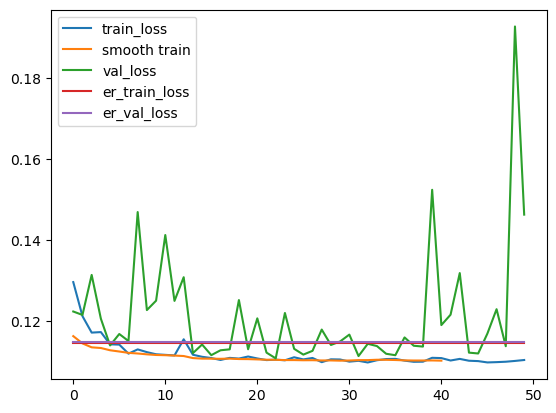

In [696]:
# Training
bs = 32
train_dataloader = utils.nx_list_to_dataloader(nx_dataset["train"], bs=bs)
val_dataloader = utils.nx_list_to_dataloader(nx_dataset["test"], bs=bs)
test_dataloader = utils.nx_list_to_dataloader(nx_dataset["test"], bs=bs)
n_epochs = 50 # you can try epoches if you want


args_simple = {'num_MLP_layers': 4,
        'num_GNN_layers': 4,
        'input_dims': 1,
        'hidden_dims': 256,
        'hidden_MLP_dims': 256,
        'output_dims': 2}
simple_model = SimpleModel(**args_simple).to(device)
lr=2e-4
simple_model = train_model(simple_model, train_dataloader, val_dataloader, n_epochs, noise_dist, T, None,lr)

### Question 2.6 - Generation (Reverse Process) [2 points]

With the trained model, we can now generate new graphs from uniform noise!

As discussed in D3PM (*Austin* et al., D3PM, 2021) and DiGress, for discrete data $X$, the generation is done step by step from $t=T$ to $t=1$.

Intuitively, the procedure is as follows:
- first, use the trained model $f_\theta$ to predict a distribution over $x_0$.
- noise the previously obtained distribution for $x_0$ back $x_{t-1}$ using the posterior of the forward process, given by:

$$
q(x_{t-1}|x_t,x_0)=\frac{q(x_t|x_{t-1}, x_0)q(x_{t-1}|x_0)}{q(x_t|x_0)} = Cat(x_{t-1};p=\frac{x_tQ_t^\top\odot x_0\bar{Q}_{t-1}}{x_0\bar{Q}_tx_t^\top})
$$

- sample a graph from the distribution over $x_{t-1}$

This step by step denoising is crucial for the success of diffusion models as it allows to deconstruct the complex task of mapping two distributions into smaller subproblems.

If some of these descriptions sounded a bit confusing, do not worry, we provide the (almost) complete code for it. You only have to care about the sampling of the number of nodes - as simple as for the ER model! Nevertheless, if you are interested, you are free to check its full implementation below.

**2.6.1. [2 points]** **Sample the number of nodes** (`n_nodes`) for the graph to be generated, and **retrieve the node mask** (`node_mask`) with it.

In [697]:
def sample_graph(model, noise_dist, T, n_graphs, num_timesteps_to_save=5, eigen_feats=None):
    seed_torch(0)
    max_n_nodes = len(n_nodes_dist) - 1
    de = len(noise_dist)

    n_nodes = torch.multinomial(n_nodes_dist, n_graphs, replacement=True) 
    node_mask=torch.zeros(n_graphs, max_n_nodes).bool()
    for i in range(n_graphs):
        node_mask[i, :n_nodes[i]] = True

    # sample a purely noised graph at step T
    limit_dist = noise_dist.repeat(n_graphs * max_n_nodes * max_n_nodes, 1)
    limit_E = limit_dist.multinomial(1, replacement=True)
    limit_E = limit_E.reshape(n_graphs, max_n_nodes, max_n_nodes)
    limit_E = torch.nn.functional.one_hot(limit_E, 2).float()
    limit_E = utils.symmetrize(limit_E)

    holder = PlaceHolder(X=torch.ones(n_graphs, max_n_nodes, 1),
                         E=limit_E,
                         y=torch.Tensor([1]).unsqueeze(-1).repeat(n_graphs, 1),).to(device).mask(node_mask)

    saving_steps = torch.linspace(0, T, num_timesteps_to_save).round()
    saved_holders = [holder.to('cpu')]  # save initial holder
    print("Saving timesteps: ", saving_steps)
    model.eval()

    with torch.no_grad():
        for t in tqdm(range(1, T+1)[::-1]):
            steps = torch.Tensor([t]).unsqueeze(-1).repeat(n_graphs, 1).to(device)
            steps_next = steps - 1
            holder.y = steps / T

            if eigen_feats is not None:
                add_feats = eigen_feats(holder.E, node_mask)
                holder.X = torch.cat((holder.X, add_feats[2], add_feats[3]), -1)
                holder.y = torch.cat((holder.y, add_feats[0], add_feats[1]), -1)

            pred_G0 = model(holder, node_mask)
            pred_E = torch.softmax(pred_G0.E, dim=-1)
            shape_E = pred_E.shape
            E_t = holder.E.to(torch.float32)              # bs, n, n, 2

            # transition matrix used in the reverse process of size (bs, 2, 2)
            Qtb = get_Q_t_bar(all_alphas_bar[steps[:, 0].long().to('cpu')], noise_dist, e_class=2).to(device)
            Qsb = get_Q_t_bar(all_alphas_bar[steps_next[:, 0].long().to('cpu')], noise_dist, e_class=2).to(device)
            Qt = get_Q_t(all_betas[steps[:, 0].long().to('cpu')], noise_dist, e_class=2).to(device)

            # posterior computation
            E_t = E_t.flatten(start_dim=1, end_dim=-2).to(torch.float32)            # bs x N x dt

            Qt_T = Qt.transpose(-1, -2)                 # bs, dt, d_t-1
            left_term = E_t @ Qt_T                      # bs, N, d_t-1
            left_term = left_term.unsqueeze(dim=2)      # bs, N, 1, d_t-1

            right_term = Qsb.unsqueeze(1)               # bs, 1, d0, d_t-1
            numerator = left_term * right_term          # bs, N, d0, d_t-1

            X_t_transposed = E_t.transpose(-1, -2)      # bs, dt, N

            prod = Qtb @ X_t_transposed                 # bs, d0, N
            prod = prod.transpose(-1, -2)               # bs, N, d0
            denominator = prod.unsqueeze(-1)            # bs, N, d0, 1
            denominator[denominator == 0] = 1e-6

            p_s_and_t_given_0_E = numerator / denominator

            # noise back
            pred_E = pred_E.reshape((n_graphs, -1, pred_E.shape[-1]))
            weighted_E = pred_E.unsqueeze(-1) * p_s_and_t_given_0_E        # bs, N, d0, d_t-1
            unnormalized_prob_E = weighted_E.sum(dim=-2)
            unnormalized_prob_E[torch.sum(unnormalized_prob_E, dim=-1) == 0] = 1e-5
            prob_E = unnormalized_prob_E / torch.sum(unnormalized_prob_E, dim=-1, keepdim=True)
            prob_E = prob_E.reshape(n_graphs, max_n_nodes, max_n_nodes, pred_E.shape[-1])

            # sample at timestep t-1
            E_s = prob_E.reshape(-1, de).multinomial(1, replacement=True)
            E_s = torch.nn.functional.one_hot(E_s, 2).float().reshape(shape_E)
            E_s = utils.symmetrize(E_s)

            assert (E_s == torch.transpose(E_s, 1, 2)).all()
            assert (E_s.shape == E_s.shape)
            holder = PlaceHolder(X=torch.ones(n_graphs, max_n_nodes, 1).to(device),
                                E=E_s, y=steps_next/T).to(device).mask(node_mask)
            # Save graphs
            if t-1 in saving_steps:
                saved_holders.append(holder.to('cpu'))

    return holder, saved_holders

The following block enables you to sample new graphs with the trained model.

In [698]:

num_graphs_to_generate = len(nx_dataset["test"])

simple_model_graphs, simple_model_intermediate_graphs = sample_graph(simple_model, noise_dist, T, num_graphs_to_generate, num_timesteps_to_save=5, eigen_feats=None)

graphs_to_eval["simple"] = simple_model_graphs.to_nx_graph_list()

Saving timesteps:  tensor([   0.,  250.,  500.,  750., 1000.])


100%|██████████| 1000/1000 [02:14<00:00,  7.43it/s]


In [699]:
nx_simple_model_graphs= simple_model_graphs.to_nx_graph_list()

# Average degree for the training set
simple_model_avg_degree = np.mean([np.mean(list(dict(nx_graph.degree()).values())) for nx_graph in nx_simple_model_graphs])
print(f"simple_model_avg_degree: {simple_model_avg_degree}")

# Average clustering coefficient for the training set
simple_model_avg_clustering = np.mean([np.mean(list(nx.clustering(nx_graph).values())) for nx_graph in nx_simple_model_graphs])
print(f"simple_model_avg_clustering: {simple_model_avg_clustering}")

total_num_edgs=0
for nx_graph in nx_simple_model_graphs:
    total_num_edgs+=nx_graph.number_of_edges()
print(f"average_num_edgs: {total_num_edgs/(len(nx_simple_model_graphs)*36)}")

simple_model_avg_degree: 6.558024691358026
simple_model_avg_clustering: 0.8065843621399177
average_num_edgs: 0.8197530864197531


# **Visualization and Evaluation**


### Visualization 

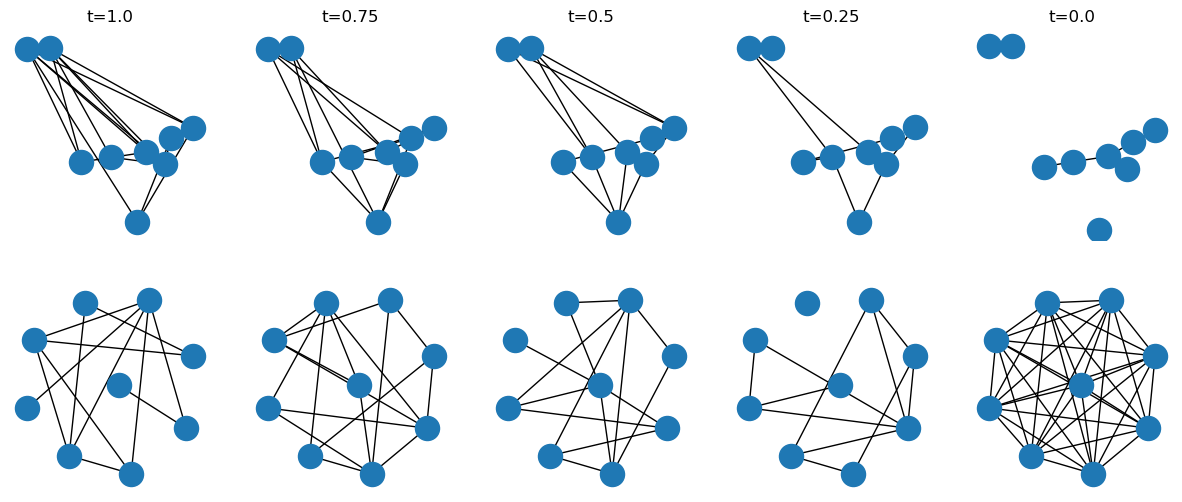

In [700]:
utils.plot_intermediate_graphs(simple_model_intermediate_graphs, T, 2)

In [701]:
print(len(nx_dataset["train"]))

300


### Quantitative Comparison 

As noticed in Part 1, evaluating graph generation just based on visual inspection is not enough. We need to compare the generated graphs quantitatively. One common approach in graph generation is to compare populations of graph-wise statistics. In this case, we will consider two different statistics:
- The degree distribution of the nodes.
- The clustering coefficient of the nodes.

For each graph, we will get a distribution (in practice, an histogram) of nodes degrees and a distribution (similarly, an histogram) of node clustering coefficients. Consequently for a graph dataset, we will get a set of histograms for each statistic. Therefore, we can compare how similar two datasets are in terms of the chosen statistic by comparing the two sets of histograms through some notion of "distance" between distributions. The more similar the two sets of histograms are, the more similar the two datasets are (at least, in terms of that statistic), so smaller should be the distance between them. In graph generation, it is usual to use the Maximum Mean Discrepancy (MMD) as such notion of "distance". You do not have to worry too much about it, just know that it is a measure of the similarity of distributions.

Finally, since such notion of "distance" is not easily interpretable, we consider as a final result the following ratio (with some abuse of notation):

$$
\frac{\operatorname{MMD} \, (\text{generated}, \text{test})}{\operatorname{MMD} \, (\text{train}, \text{test})},
$$

where generated, train, and test consist of the histograms of a statistic for the generated graphs, the training graphs, and the test graphs, respectively. This ratio will be our final evaluation metric, since in principle, the best MMD we could hope for is the one between the training and test datasets, as the training dataset is the one we are trying to approximate. Therefore, the expected optimal (minimum) value is 1.

<!-- In graph generation, it is usual to use the [Maximum Mean Discrepancy](https://jmlr.csail.mit.edu/papers/v13/gretton12a.html) (MMD) as such notion of "distance". You do not have to worry too much about it, just know that it is a measure of the similarity of distributions.

To make you more familiar, an alternative to MMD could be the widely know Kullback-Leibler divergence (it suffers from some limitations, such as the assymetry in its inputs, sensitivity to zero probabilities, etc). In any case, we provide you an implementation of the MMD function.

Finally, since such notion of "distance" is not easily interpretable, we consider as a final result the following ratio (with some abuse of notation):

$$
\frac{\operatorname{MMD} \, (\text{generated}, \text{test})}{\operatorname{MMD} \, (\text{train}, \text{test})},
$$

where generated, train, and test consist of the histograms of a statistic for the generated graphs, the training graphs, and the test graphs, respectively. This ratio will be our final evaluation metric, since in principle, the best MMD we could hope for is the one between the training and test datasets, as the training dataset is the one we are trying to approximate. Therefore, the expected optimal (minimum) value is 1. -->

In [702]:
def get_degree_hist_array(nx_dataset: List[nx.Graph], max_degree: int =20) -> np.ndarray:
    """The output should be an np.array of shape (len(nx_dataset), max_degree),  where each row corresponds to the degree histogram obtained for a different graph of the dataset."""
    deg_hist_array = np.zeros((len(nx_dataset), max_degree))
    for i, g in enumerate(nx_dataset):
        deg = np.array([g.degree(node) for node in g.nodes()])
        deg_hist, _ = np.histogram(deg, bins=np.arange(max_degree+1))
        deg_hist_array[i] = deg_hist
    return deg_hist_array

def get_clustering_hist_array(nx_dataset, num_bins=10) -> np.ndarray:
    """The output should be an np.array of shape (len(nx_dataset), num_bins), where each row corresponds to the node cluster coefficient histogram obtained for a different graph of the dataset."""
    clustering_hist_array = np.zeros((len(nx_dataset), num_bins))
    for i, g in enumerate(nx_dataset):
        clustering = np.array(list(nx.clustering(g).values()))
        clustering_hist, _ = np.histogram(clustering, bins=np.linspace(0, 1, num_bins+1))
        clustering_hist_array[i] = clustering_hist
    return clustering_hist_array

dict_stat_fn = {
    "degree": get_degree_hist_array,
    "clustering": get_clustering_hist_array,
}
final_results = utils.QuantitativeResults(dict_stat_fn=dict_stat_fn, train_dataset=nx_dataset["train"], test_dataset=nx_dataset["test"])
for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

,ref,ER,simple
degree,1,5.295140,144.241599
clustering,1,1.972899,48.385561


In [703]:
num_graphs = len(nx_dataset["test"])

# Check graph isomorphism
unique_graphs = []
for i in range(num_graphs):
    is_unique = True
    for unique_graph in unique_graphs:
        if nx.is_isomorphic(nx_simple_model_graphs[i], unique_graph):
            is_unique = False
            break
    if is_unique:
        unique_graphs.append(nx_simple_model_graphs[i])

# Calculate the probability of generating a unique graph
probability_unique = len(unique_graphs) / num_graphs

print("Number of unique graphs:", len(unique_graphs))
print("Probability of generating a unique graph:", probability_unique)


Number of unique graphs: 14
Probability of generating a unique graph: 0.3111111111111111


### Improving results using different GNN & Eigenfeatures

In this section, we will implement a more sophisticated architecture, `GraphTransformer`, provided in `transformer_model.py`. This new architecture enhances interactions through:

- Modules that effectively integrate node, edge, and graph-level features;
- A refined masking mechanism that allows operations on dense tensors instead of relying solely on edge lists.

Your task is to readily utilize this architecture, and compare its performance with the simpler model previously discussed.

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [02:06<00:00,  2.53s/it]


0.0847218856215477


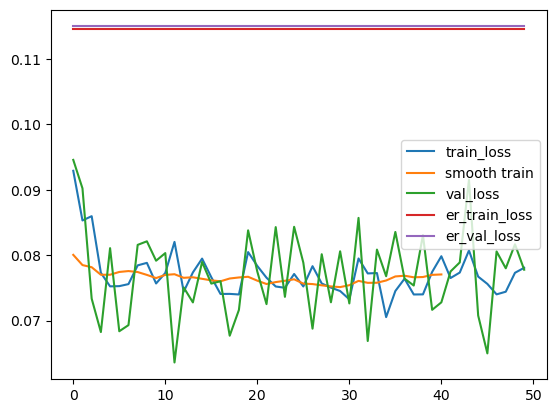

Saving timesteps:  tensor([   0.,  250.,  500.,  750., 1000.])


100%|██████████| 1000/1000 [00:53<00:00, 18.80it/s]


In [704]:

from transformer_model import GraphTransformer

# Some hyper-parameters by default you can use - of course you can change them if you want !

args_gt = {'n_layers': 4,
        'n_head': 8,
        'input_dims': {'X': 1, 'E': 2, 'y': 1},
        'hidden_dims': {'X': 256, 'E': 256, 'y': 256, 'dx': 64, 'de': 64, 'dy': 64},
        'output_dims': {'X': 1, 'E': 2, 'y': 1},}
n_epochs = 50


# Train
gt_model = GraphTransformer(**args_gt).to(device)
lr=2e-4
gt_model = train_model(gt_model, train_dataloader, val_dataloader, n_epochs, noise_dist, T, None,lr)
# Generate
num_graphs_to_generate = len(nx_dataset["test"])
gt_model_graphs, gt_model_intermediate_graphs = sample_graph(gt_model, noise_dist, T, num_graphs_to_generate, num_timesteps_to_save=5, eigen_feats=None)
graphs_to_eval["gt"] = gt_model_graphs.to_nx_graph_list()


,ref,ER,simple,gt
degree,1,5.295140,144.241599,4.566003
clustering,1,1.972899,48.385561,0.629733


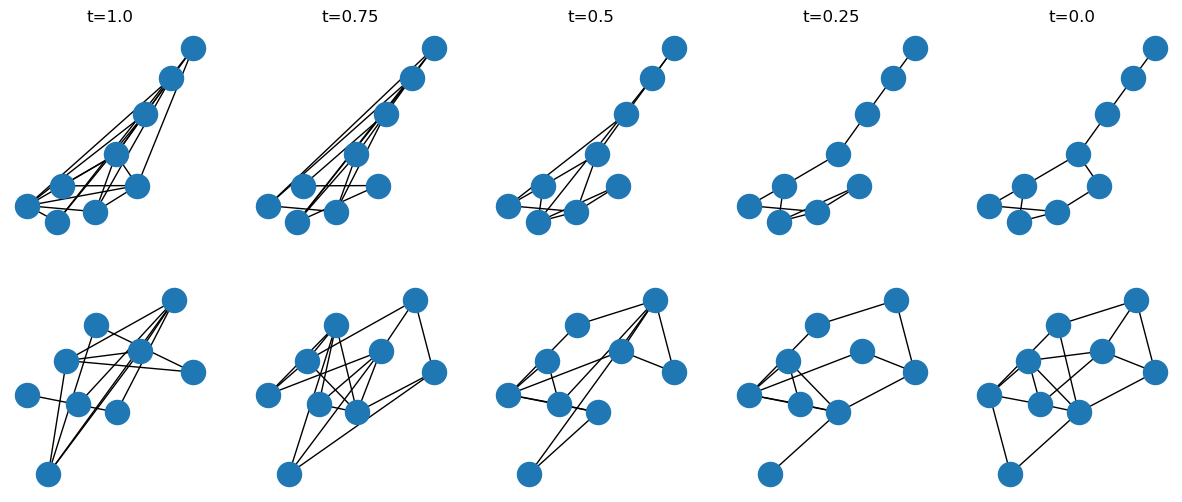

In [705]:
# Visualize and evaluate
graphs_to_eval["gt"] = gt_model_graphs.to_nx_graph_list()
utils.plot_intermediate_graphs(gt_model_intermediate_graphs, T, 2)
final_results = utils.QuantitativeResults(dict_stat_fn=dict_stat_fn, train_dataset=nx_dataset["train"], test_dataset=nx_dataset["test"])
for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

In [706]:
nx_gt_model_graphs= gt_model_graphs.to_nx_graph_list()

# Average degree for the training set
simple_model_avg_degree = np.mean([np.mean(list(dict(nx_graph.degree()).values())) for nx_graph in nx_gt_model_graphs])
print(f"gt_model_avg_degree: {simple_model_avg_degree}")

# Average clustering coefficient for the training set
simple_model_avg_clustering = np.mean([np.mean(list(nx.clustering(nx_graph).values())) for nx_graph in nx_gt_model_graphs])
print(f"gt_model_avg_clustering: {simple_model_avg_clustering}")

total_num_edgs=0
for nx_graph in nx_gt_model_graphs:
    total_num_edgs+=nx_graph.number_of_edges()
print(f"average_num_edgs: {total_num_edgs/(len(nx_gt_model_graphs)*36)}")

gt_model_avg_degree: 2.65679012345679
gt_model_avg_clustering: 0.2902057613168724
average_num_edgs: 0.33209876543209876


In [707]:
num_graphs = len(nx_dataset["test"])

# Check graph isomorphism
unique_graphs = []
for i in range(num_graphs):
    is_unique = True
    for unique_graph in unique_graphs:
        if nx.is_isomorphic(nx_gt_model_graphs[i], unique_graph):
            is_unique = False
            break
    if is_unique:
        unique_graphs.append(nx_gt_model_graphs[i])

# Calculate the probability of generating a unique graph
probability_unique = len(unique_graphs) / num_graphs

print("Number of unique graphs:", len(unique_graphs))
print("Probability of generating a unique graph:", probability_unique)


Number of unique graphs: 45
Probability of generating a unique graph: 1.0


### Using eigenfeatures

eigen_feats=<assignment3_utils.EigenFeatures object at 0x00000223C4EF2BD0>


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:50<00:00,  2.20s/it]


0.09640266001224518


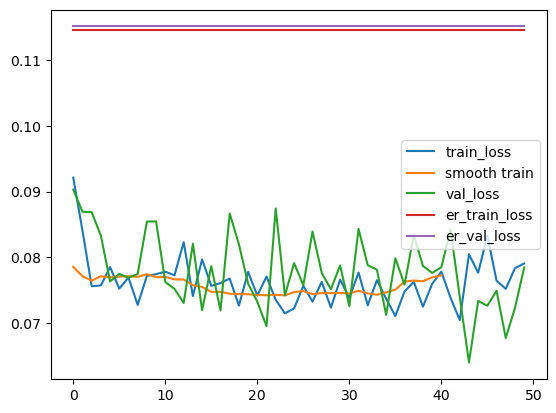

Saving timesteps:  tensor([   0.,  250.,  500.,  750., 1000.])


100%|██████████| 1000/1000 [00:56<00:00, 17.64it/s]


In [708]:
args_gt_pp = {'n_layers': 4,
        'n_head': 8,
        'input_dims': {'X': 7, 'E': 2, 'y': 7},
        'hidden_dims': {'X': 256, 'E': 256, 'y': 256, 'dx': 64, 'de': 64, 'dy': 64},
        'output_dims': {'X': 1, 'E': 2, 'y': 1},}
n_epochs=50
eigen_feats = utils.EigenFeatures('all')
print(f"eigen_feats={eigen_feats}")


# Train
gt_pp_model = GraphTransformer(**args_gt_pp).to(device)
lr=2e-4
gt_pp_model = train_model(gt_pp_model, train_dataloader, val_dataloader, n_epochs, noise_dist, T, eigen_feats,lr)
# Generate
num_graphs_to_generate = len(nx_dataset["test"])
gt_pp_model_graphs, gt_pp_model_intermediate_graphs = sample_graph(gt_pp_model, noise_dist, T, num_graphs_to_generate, num_timesteps_to_save=5, eigen_feats=eigen_feats)



,ref,ER,simple,gt,gt_pp
degree,1,5.295140,144.241599,4.566003,2.170345
clustering,1,1.972899,48.385561,0.629733,0.485582


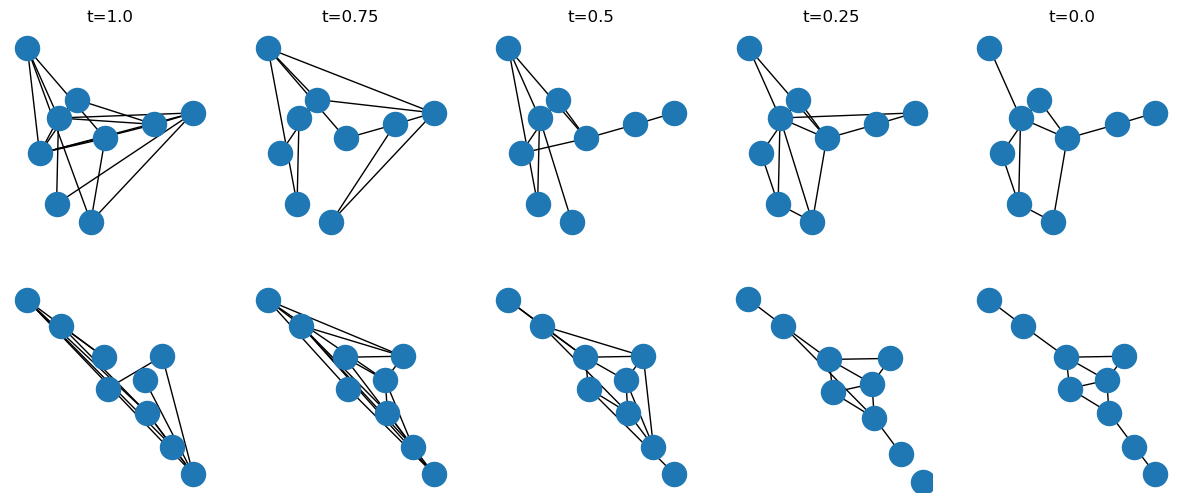

In [709]:
graphs_to_eval["gt_pp"] = gt_pp_model_graphs.to_nx_graph_list()
# Visualize and evaluate
utils.plot_intermediate_graphs(gt_pp_model_intermediate_graphs, T, 2)
final_results = utils.QuantitativeResults(dict_stat_fn=dict_stat_fn, train_dataset=nx_dataset["train"], test_dataset=nx_dataset["test"])
for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

In [710]:
nx_gt_pp_model_graphs= gt_pp_model_graphs.to_nx_graph_list()

# Average degree for the training set
simple_model_avg_degree = np.mean([np.mean(list(dict(nx_graph.degree()).values())) for nx_graph in nx_gt_pp_model_graphs])
print(f"gt_pp_model_avg_degree: {simple_model_avg_degree}")

# Average clustering coefficient for the training set
simple_model_avg_clustering = np.mean([np.mean(list(nx.clustering(nx_graph).values())) for nx_graph in nx_gt_pp_model_graphs])
print(f"gt_pp_model_avg_clustering: {simple_model_avg_clustering}")

total_num_edgs=0
for nx_graph in nx_gt_pp_model_graphs:
    total_num_edgs+=nx_graph.number_of_edges()
print(f"average_num_edgs: {total_num_edgs/(len(nx_gt_pp_model_graphs)*36)}")

gt_pp_model_avg_degree: 2.5234567901234572
gt_pp_model_avg_clustering: 0.24016460905349793
average_num_edgs: 0.3154320987654321


In [711]:
num_graphs = len(nx_dataset["test"])

# Check graph isomorphism
unique_graphs = []
for i in range(num_graphs):
    is_unique = True
    for unique_graph in unique_graphs:
        if nx.is_isomorphic(nx_gt_pp_model_graphs[i], unique_graph):
            is_unique = False
            break
    if is_unique:
        unique_graphs.append(nx_gt_pp_model_graphs[i])

# Calculate the probability of generating a unique graph
probability_unique = len(unique_graphs) / num_graphs

print("Number of unique graphs:", len(unique_graphs))
print("Probability of generating a unique graph:", probability_unique)


Number of unique graphs: 45
Probability of generating a unique graph: 1.0


# **Part 3: Digress with marginal probabilitis**




In [712]:
def get_Q_t(betas: torch.Tensor, noise_dist: torch.Tensor, e_class=2) -> torch.Tensor:
    """
    Input:
        - betas, (bs, )
        - noise_dist, (e_class, 1) -> the noise distribution at step $t=1,000$, here we take by default (0.5, 0.5)
        - e_class, number of classes for edges
    Output:
        - q_e, (bs, e_class, e_class)
    """

    q_e = torch.zeros(betas.shape[0], e_class, e_class)
    for i in range(e_class):
        q_e[:, i, i] = 1 - (betas*noise_dist.sum()).view(-1)
    noise=noise_dist.unsqueeze(0).repeat(e_class,1)
    for batch in range(betas.shape[0]):
        q_e[batch,:,:]=q_e[batch,:,:]+betas[batch]*noise 
    assert ((q_e.sum(dim=2) - 1.0).abs() < 1e-4).all()  # ensure each row of q_e represents a distribution
    return q_e

def get_Q_t_bar(alphas_bar: torch.Tensor, noise_dist: torch.Tensor, e_class: int =2) -> torch.Tensor:
    """
    Input:
        - alphas_bar, (bs, )
        - noise_dist, (e_class, 1) -> the noise distribution at step $t=1,000$, here we take by default (0.5, 0.5)
        - e_class, number of classes for edges
    Output:
        - q_e, (bs, e_class, e_class)
    """

    q_e = torch.zeros(alphas_bar.shape[0], e_class, e_class)
    for i in range(e_class):
        q_e[:, i, i] = alphas_bar.view(-1)
    noise=noise_dist.unsqueeze(0).repeat(e_class,1)
    for batch in range(alphas_bar.shape[0]):  
        q_e[batch,:,:]=q_e[batch,:,:]+(1-alphas_bar[batch])*noise
    assert ((q_e.sum(dim=2) - 1.0).abs() < 1e-4).all()  # ensure each row of q_e represents a distribution
    return q_e


# example for test
marginal_noise_dist= torch.Tensor([1-0.30574074074074076, 0.30574074074074076])  #Change this from [0.5,0.5]
betas_t = utils.get_betas(1000)[:2]
alphas_bar_t = utils.get_alphas_bar(utils.get_alphas(1000))[:2]
Qt = get_Q_t(betas_t, noise_dist=marginal_noise_dist, e_class=2)
Qt_bar = get_Q_t_bar(alphas_bar_t, noise_dist=marginal_noise_dist, e_class=2)

print(f"Qt: {Qt}, {Qt.shape}")
print(f"Qt_bar: {Qt_bar}, {Qt_bar.shape}")


Qt: tensor([[[9.9999e-01, 1.2609e-05],
         [2.8632e-05, 9.9997e-01]],

        [[9.9999e-01, 1.4091e-05],
         [3.1997e-05, 9.9997e-01]]]), torch.Size([2, 2, 2])
Qt_bar: tensor([[[9.9997e-01, 3.0579e-05],
         [6.9437e-05, 9.9993e-01]],

        [[9.9994e-01, 6.1158e-05],
         [1.3887e-04, 9.9986e-01]]]), torch.Size([2, 2, 2])


c:\Users\alexk\anaconda3\envs\project1\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 50/50 [01:22<00:00,  1.65s/it]

0.10840759426355362


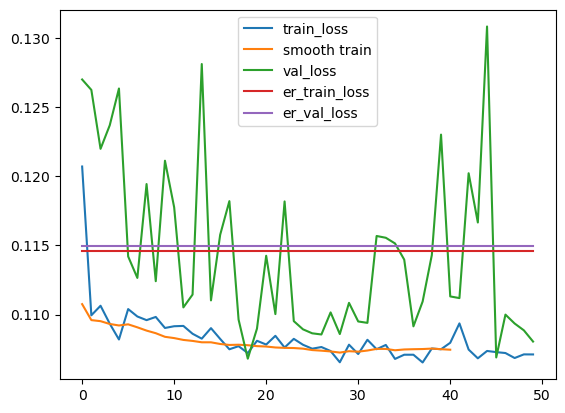

In [728]:
# Training
bs = 32
nx_dataset["train"]=nx_dataset["train"]
train_dataloader = utils.nx_list_to_dataloader(nx_dataset["train"], bs=bs)
val_dataloader = utils.nx_list_to_dataloader(nx_dataset["test"], bs=bs)
test_dataloader = utils.nx_list_to_dataloader(nx_dataset["test"], bs=bs)
n_epochs = 50 # you can try epoches if you want


args_simple = {'num_MLP_layers': 4,
        'num_GNN_layers': 4,
        'input_dims': 1,
        'hidden_dims': 256,
        'hidden_MLP_dims': 256,
        'output_dims': 2}
simple_model = SimpleModel(**args_simple).to(device)
lr=2e-5
simple_model = train_model(simple_model, train_dataloader, val_dataloader, n_epochs, marginal_noise_dist, T, None,lr)

In [714]:
num_graphs_to_generate = len(nx_dataset["test"])

marginal_simple_model_graphs, marginal_simple_model_intermediate_graphs = sample_graph(simple_model, marginal_noise_dist, T, num_graphs_to_generate, num_timesteps_to_save=5, eigen_feats=None)
graphs_to_eval["marginal_simple"] = marginal_simple_model_graphs.to_nx_graph_list()

Saving timesteps:  tensor([   0.,  250.,  500.,  750., 1000.])


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]


### Visualization

,ref,ER,simple,gt,gt_pp,marginal_simple
degree,1,5.295140,144.241599,4.566003,2.170345,256.173578
clustering,1,1.972899,48.385561,0.629733,0.485582,92.220148


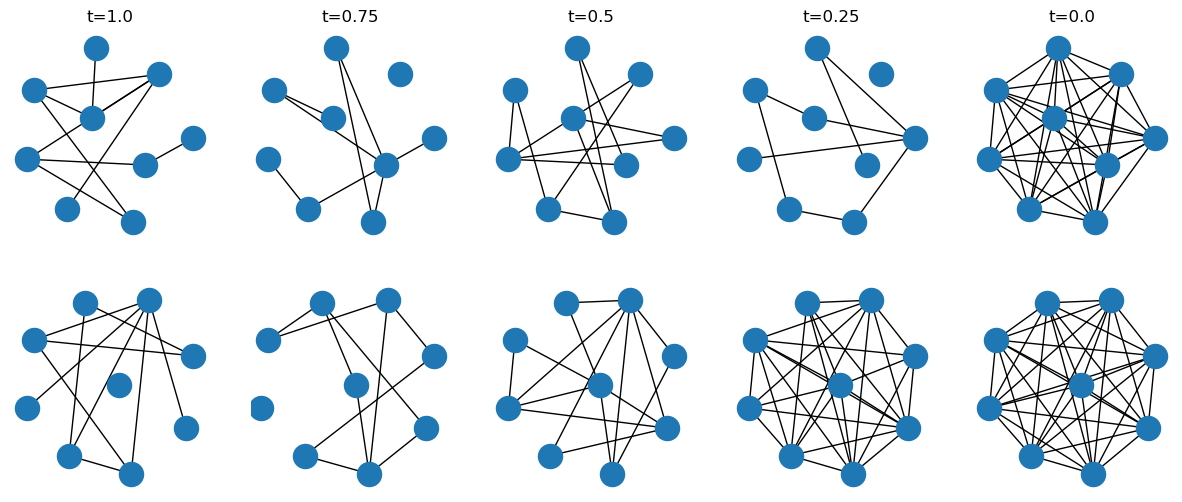

In [715]:
utils.plot_intermediate_graphs(marginal_simple_model_intermediate_graphs, T, 2)

graphs_to_eval["marginal_simple"] = marginal_simple_model_graphs.to_nx_graph_list()

for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

In [716]:
nx_marginal_simple_model_graphs= marginal_simple_model_graphs.to_nx_graph_list()

# Average degree for the training set
simple_model_avg_degree = np.mean([np.mean(list(dict(nx_graph.degree()).values())) for nx_graph in nx_marginal_simple_model_graphs])
print(f"marginal_simple_model_avg_degree: {simple_model_avg_degree}")

# Average clustering coefficient for the training set
simple_model_avg_clustering = np.mean([np.mean(list(nx.clustering(nx_graph).values())) for nx_graph in nx_marginal_simple_model_graphs])
print(f"marginal_simple_model_avg_clustering: {simple_model_avg_clustering}")

total_num_edgs=0
for nx_graph in nx_marginal_simple_model_graphs:
    total_num_edgs+=nx_graph.number_of_edges()
print(f"average_num_edgs: {total_num_edgs/(len(nx_marginal_simple_model_graphs)*36)}")

marginal_simple_model_avg_degree: 7.970370370370371
marginal_simple_model_avg_clustering: 0.9967078189300412
average_num_edgs: 0.9962962962962963


In [717]:
num_graphs = len(nx_dataset["test"])

# Check graph isomorphism
unique_graphs = []
for i in range(num_graphs):
    is_unique = True
    for unique_graph in unique_graphs:
        if nx.is_isomorphic(nx_marginal_simple_model_graphs[i], unique_graph):
            is_unique = False
            break
    if is_unique:
        unique_graphs.append(nx_marginal_simple_model_graphs[i])

# Calculate the probability of generating a unique graph
probability_unique = len(unique_graphs) / num_graphs

print("Number of unique graphs:", len(unique_graphs))
print("Probability of generating a unique graph:", probability_unique)


Number of unique graphs: 4
Probability of generating a unique graph: 0.08888888888888889


### Improving results using different GNN & Eigenfeatures

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


0.08097167313098907


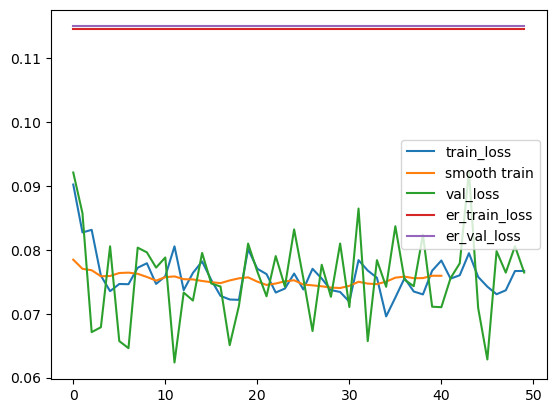

Saving timesteps:  tensor([   0.,  250.,  500.,  750., 1000.])


100%|██████████| 1000/1000 [00:58<00:00, 17.11it/s]


In [718]:

from transformer_model import GraphTransformer

# Some hyper-parameters by default you can use - of course you can change them if you want !

args_gt = {'n_layers': 4,
        'n_head': 8,
        'input_dims': {'X': 1, 'E': 2, 'y': 1},
        'hidden_dims': {'X': 256, 'E': 256, 'y': 256, 'dx': 64, 'de': 64, 'dy': 64},
        'output_dims': {'X': 1, 'E': 2, 'y': 1},}
n_epochs = 50



# Train
gt_model = GraphTransformer(**args_gt).to(device)
lr=2e-4
gt_model = train_model(gt_model, train_dataloader, val_dataloader, n_epochs, marginal_noise_dist, T, None,lr)
# Generate
num_graphs_to_generate = len(nx_dataset["test"])
marginal_gt_model_graphs, marginal_gt_model_intermediate_graphs = sample_graph(gt_model, marginal_noise_dist, T, num_graphs_to_generate, num_timesteps_to_save=5, eigen_feats=None)
graphs_to_eval["marginal_gt"] = marginal_gt_model_graphs.to_nx_graph_list()


,ref,ER,simple,gt,gt_pp,marginal_simple,marginal_gt
degree,1,5.295140,144.241599,4.566003,2.170345,256.173578,5.755244
clustering,1,1.972899,48.385561,0.629733,0.485582,92.220148,1.440283


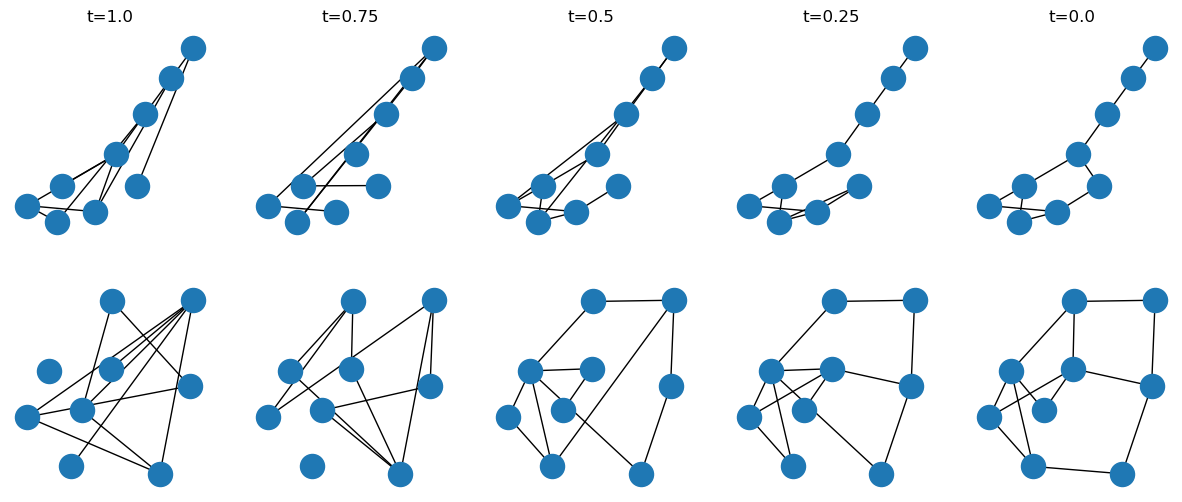

In [719]:
# Visualize and evaluate
utils.plot_intermediate_graphs(marginal_gt_model_intermediate_graphs, T, 2)

graphs_to_eval["marginal_gt"] = marginal_gt_model_graphs.to_nx_graph_list()

for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()

In [720]:
nx_marginal_gt_model_graphs= marginal_gt_model_graphs.to_nx_graph_list()

# Average degree for the training set
gt_model_avg_degree = np.mean([np.mean(list(dict(nx_graph.degree()).values())) for nx_graph in nx_marginal_gt_model_graphs])
print(f"marginal_gt_model_avg_degree: {gt_model_avg_degree}")

# Average clustering coefficient for the training set
gt_model_avg_clustering = np.mean([np.mean(list(nx.clustering(nx_graph).values())) for nx_graph in nx_marginal_gt_model_graphs])
print(f"marginal_gt_model_avg_clustering: {gt_model_avg_clustering}")

total_num_edgs=0
for nx_graph in nx_marginal_gt_model_graphs:
    total_num_edgs+=nx_graph.number_of_edges()
print(f"average_num_edgs: {total_num_edgs/(len(nx_marginal_gt_model_graphs)*36)}")

marginal_gt_model_avg_degree: 2.419753086419753
marginal_gt_model_avg_clustering: 0.22345679012345682
average_num_edgs: 0.30246913580246915


In [721]:
num_graphs = len(nx_dataset["test"])

# Check graph isomorphism
unique_graphs = []
for i in range(num_graphs):
    is_unique = True
    for unique_graph in unique_graphs:
        if nx.is_isomorphic(nx_marginal_gt_model_graphs[i], unique_graph):
            is_unique = False
            break
    if is_unique:
        unique_graphs.append(nx_marginal_gt_model_graphs[i])

# Calculate the probability of generating a unique graph
probability_unique = len(unique_graphs) / num_graphs

print("Number of unique graphs:", len(unique_graphs))
print("Probability of generating a unique graph:", probability_unique)


Number of unique graphs: 45
Probability of generating a unique graph: 1.0


### Using eigenfeatures

eigen_feats=<assignment3_utils.EigenFeatures object at 0x00000223C36BED90>


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


0.09745664894580841


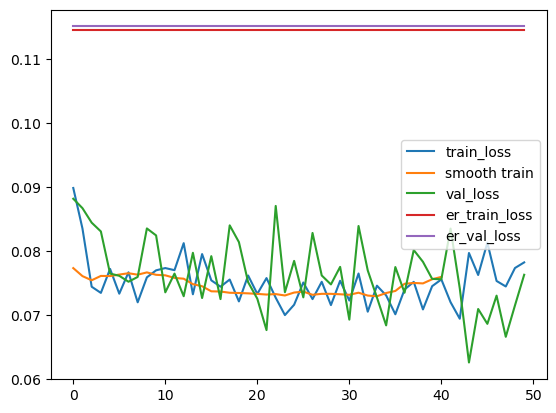

Saving timesteps:  tensor([   0.,  250.,  500.,  750., 1000.])


100%|██████████| 1000/1000 [01:05<00:00, 15.24it/s]


In [722]:
args_gt_pp = {'n_layers': 4,
        'n_head': 8,
        'input_dims': {'X': 7, 'E': 2, 'y': 7},
        'hidden_dims': {'X': 256, 'E': 256, 'y': 256, 'dx': 64, 'de': 64, 'dy': 64},
        'output_dims': {'X': 1, 'E': 2, 'y': 1},}
n_epochs=50
eigen_feats = utils.EigenFeatures('all')
print(f"eigen_feats={eigen_feats}")


# Train
gt_pp_model = GraphTransformer(**args_gt_pp).to(device)
lr=2e-4
gt_pp_model = train_model(gt_pp_model, train_dataloader, val_dataloader, n_epochs, marginal_noise_dist, T, eigen_feats,lr)
# Generate
num_graphs_to_generate = len(nx_dataset["test"])
marginal_gt_pp_model_graphs, marginal_gt_pp_model_intermediate_graphs = sample_graph(gt_pp_model, marginal_noise_dist, T, num_graphs_to_generate, num_timesteps_to_save=5, eigen_feats=eigen_feats)
graphs_to_eval["marginal_gt_pp"] = marginal_gt_pp_model_graphs.to_nx_graph_list()


,ref,ER,simple,gt,gt_pp,marginal_simple,marginal_gt,marginal_gt_pp
degree,1,5.295140,144.241599,4.566003,2.170345,256.173578,5.755244,3.569609
clustering,1,1.972899,48.385561,0.629733,0.485582,92.220148,1.440283,0.392723


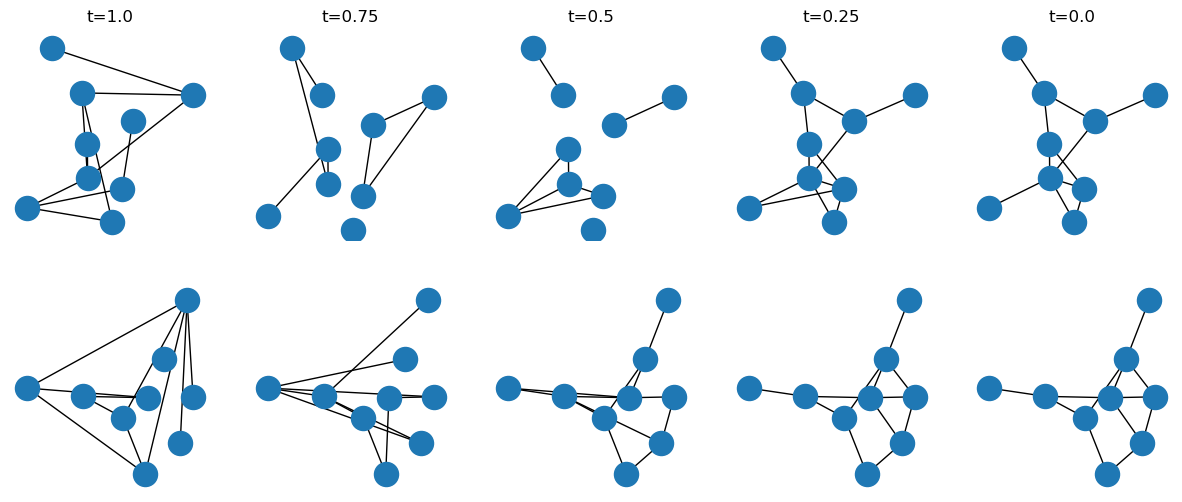

In [723]:
graphs_to_eval["marginal_gt_pp"] = marginal_gt_pp_model_graphs.to_nx_graph_list()

# Visualize and evaluate
utils.plot_intermediate_graphs(marginal_gt_pp_model_intermediate_graphs, T, 2)
final_results = utils.QuantitativeResults(dict_stat_fn=dict_stat_fn, train_dataset=nx_dataset["train"], test_dataset=nx_dataset["test"])
for gen_method, gen_dist in graphs_to_eval.items():
    final_results.add_results(gen_method, gen_dist)
final_results.show_table()


In [724]:
nx_marginal_gt_pp_model_graphs= marginal_gt_pp_model_graphs.to_nx_graph_list()

# Average degree for the training set
gt_pp_model_avg_degree = np.mean([np.mean(list(dict(nx_graph.degree()).values())) for nx_graph in nx_marginal_gt_pp_model_graphs])
print(f"marginal_gt_pp_model_avg_degree: {gt_pp_model_avg_degree}")

# Average clustering coefficient for the training set
gt_pp_model_avg_clustering = np.mean([np.mean(list(nx.clustering(nx_graph).values())) for nx_graph in nx_marginal_gt_pp_model_graphs])
print(f"marginal_gt_pp_model_avg_clustering: {gt_pp_model_avg_clustering}")

total_num_edgs=0
for nx_graph in nx_marginal_gt_pp_model_graphs:
    total_num_edgs+=nx_graph.number_of_edges()
print(f"average_num_edgs: {total_num_edgs/(len(nx_marginal_gt_pp_model_graphs)*36)}")

marginal_gt_pp_model_avg_degree: 2.612345679012346
marginal_gt_pp_model_avg_clustering: 0.2619870664315109
average_num_edgs: 0.32654320987654323


In [725]:
num_graphs = len(nx_marginal_gt_pp_model_graphs)

# Check graph isomorphism
unique_graphs = []
for i in range(num_graphs):
    is_unique = True
    for unique_graph in unique_graphs:
        if nx.is_isomorphic(nx_marginal_gt_pp_model_graphs[i], unique_graph):
            is_unique = False
            break
    if is_unique:
        unique_graphs.append(nx_marginal_gt_pp_model_graphs[i])

# Calculate the probability of generating a unique graph
probability_unique = len(unique_graphs) / num_graphs

print("Number of unique graphs:", len(unique_graphs))
print("Probability of generating a unique graph:", probability_unique)


Number of unique graphs: 45
Probability of generating a unique graph: 1.0


# **Part 4: More serious QM9 dataset**




In [726]:
import torch_geometric.datasets as datasets

# Specify the root directory where you want to download the dataset
root = 'C:/Users/alexk/OneDrive/Documents/Classes/Network_ML/assignment3'

# Download the QM9 dataset
QM9_dataset = datasets.QM9(root=root)

In [727]:
print(f"QM9_dataset[200].num_nodes: {QM9_dataset[200].num_nodes}")  
print(f"QM9_dataset[200].num_edges: {QM9_dataset[200].num_edges}")
print(f"QM9_dataset[200].num_features: {QM9_dataset[200].num_features}")
#print all dic
print(f"QM9_dataset[200]: {QM9_dataset[200]}")
print(f"QM9_dataset[200].x: {QM9_dataset[200].z}")

QM9_dataset[200].num_nodes: 11
QM9_dataset[200].num_edges: 22
QM9_dataset[200].num_features: 11
QM9_dataset[200]: Data(x=[11, 11], edge_index=[2, 22], edge_attr=[22, 4], y=[1, 19], pos=[11, 3], idx=[1], name='gdb_206', z=[11])
QM9_dataset[200].x: tensor([7, 6, 6, 7, 6, 7, 1, 1, 1, 1, 1])
